In [117]:
import rdkit
import deepchem

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline



In [118]:
data = pd.read_csv('./mlchem/logP_dataset.csv', names=['SMILES','P-Value'])
data.head()

,SMILES,P-Value
0,C[C@H]([C@@H](C)Cl)Cl,2.3
1,C(C=CBr)N,0.3
2,CCC(CO)Br,1.3
3,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O,2.0
4,CCCOCCP,0.6


In [119]:
data['Mol'] = data['SMILES'].apply(lambda x: rdkit.Chem.MolFromSmiles(x))
data.head()

,SMILES,P-Value,Mol
0,C[C@H]([C@@H](C)Cl)Cl,2.3,<rdkit.Chem.rdchem.Mol object at 0x000001FC936...
1,C(C=CBr)N,0.3,<rdkit.Chem.rdchem.Mol object at 0x000001FCC9B...
2,CCC(CO)Br,1.3,<rdkit.Chem.rdchem.Mol object at 0x000001FCC9B...
3,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O,2.0,<rdkit.Chem.rdchem.Mol object at 0x000001FCC9B...
4,CCCOCCP,0.6,<rdkit.Chem.rdchem.Mol object at 0x000001FCC9B...


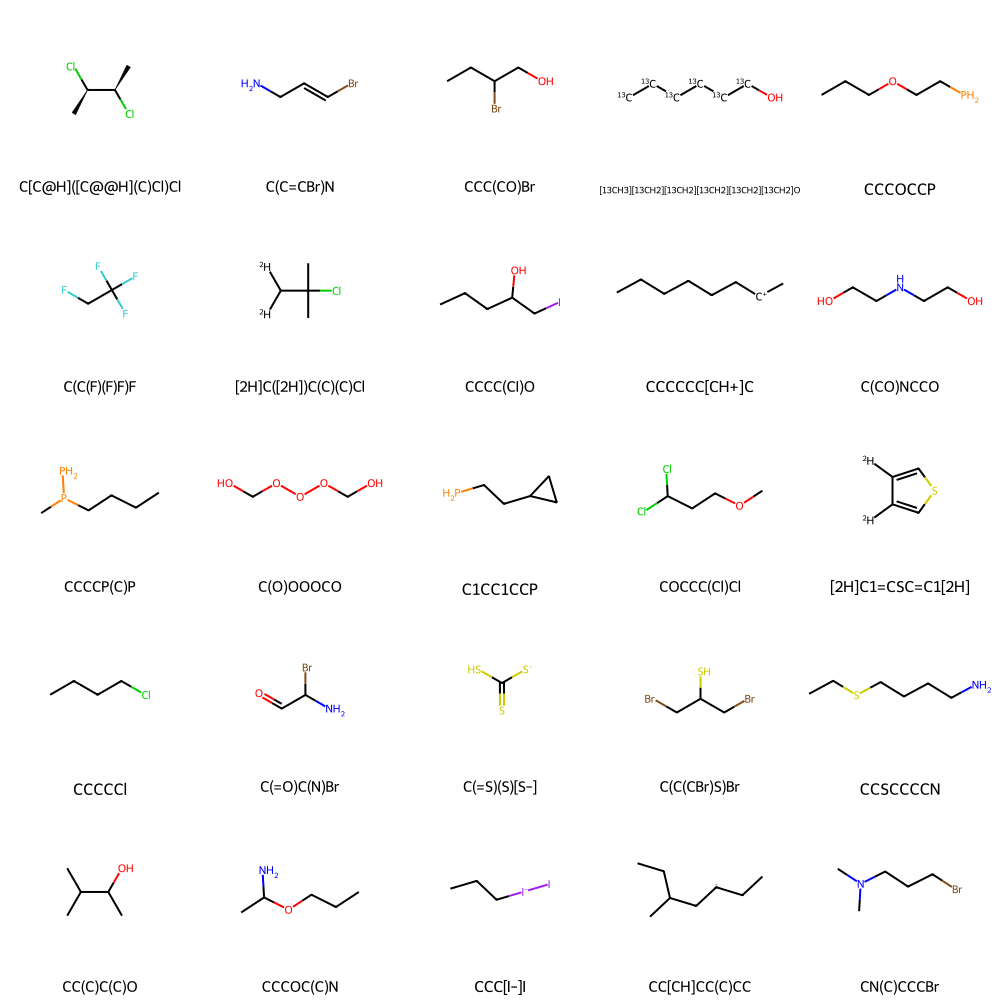

In [95]:
from rdkit.Chem import Draw
mols_sample = data['Mol'][:25]

Draw.MolsToGridImage(mols_sample, molsPerRow=5, legends=list(data['SMILES'][:25].values))

In [120]:
data['Mol'] = data['Mol'].apply(lambda x: rdkit.Chem.AddHs(x))
data['num_of_atoms'] = data['Mol'].apply(lambda x: x.GetNumAtoms())
data['num_of_heavy_atoms'] = data['Mol'].apply(lambda x: x.GetNumHeavyAtoms())
data.head()

,SMILES,P-Value,Mol,num_of_atoms,num_of_heavy_atoms
0,C[C@H]([C@@H](C)Cl)Cl,2.3,<rdkit.Chem.rdchem.Mol object at 0x000001FCA28...,14,6
1,C(C=CBr)N,0.3,<rdkit.Chem.rdchem.Mol object at 0x000001FCA28...,11,5
2,CCC(CO)Br,1.3,<rdkit.Chem.rdchem.Mol object at 0x000001FCA32...,15,6
3,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O,2.0,<rdkit.Chem.rdchem.Mol object at 0x000001FCA32...,21,7
4,CCCOCCP,0.6,<rdkit.Chem.rdchem.Mol object at 0x000001FCA32...,20,7


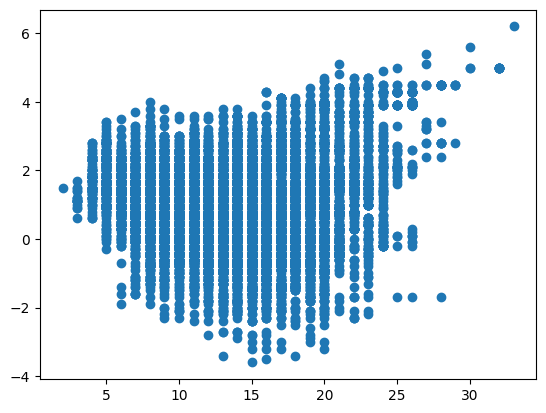

In [97]:
plt.scatter(data['num_of_atoms'].values,data['P-Value'].values)

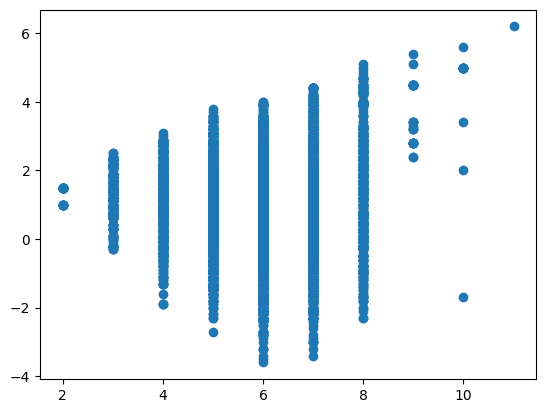

In [98]:
plt.scatter(data['num_of_heavy_atoms'].values,data['P-Value'].values)

In [99]:
def number_of_atoms(atom_list, df):
    for i in atom_list:
        data['num_of_{}_atoms'.format(i)] = df['Mol'].apply(lambda x: len(x.GetSubstructMatches(rdkit.Chem.MolFromSmiles(i))))

number_of_atoms(['C','O', 'N', 'Cl'], data)

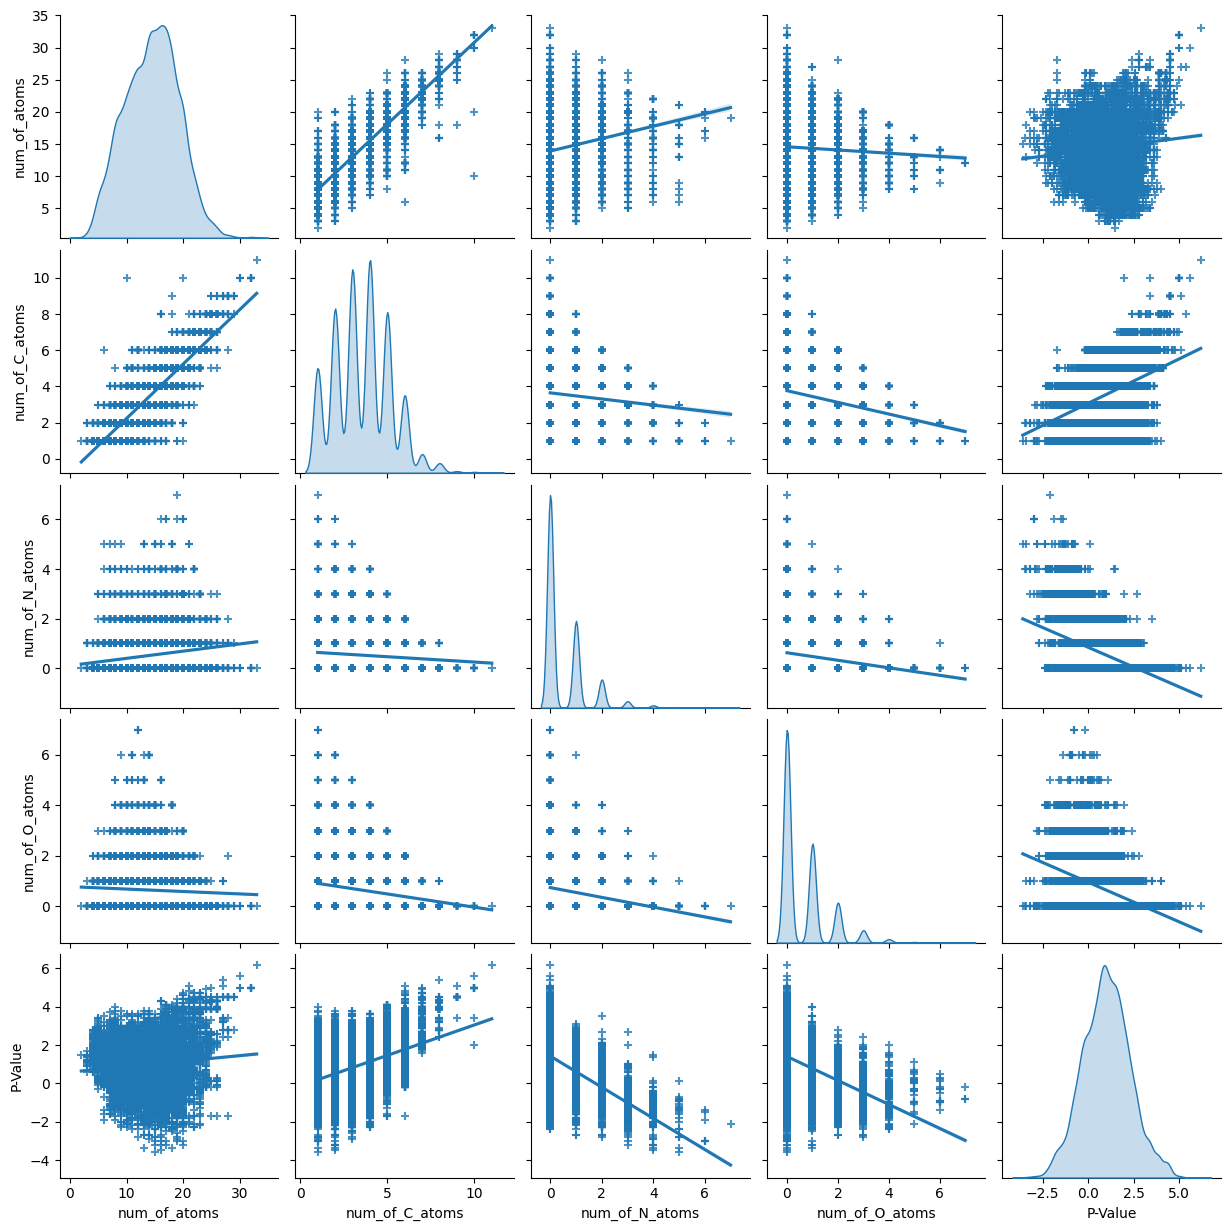

In [100]:
import seaborn as sns

sns.pairplot(data[['num_of_atoms','num_of_C_atoms','num_of_N_atoms', 'num_of_O_atoms', 'P-Value']], diag_kind='kde', kind='reg', markers='+')
plt.show()

In [86]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

x = data.drop(columns=['SMILES','Mol','P-Value'])
y = data['P-Value'].values

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [87]:
LR_model = LinearRegression()

LR_model.fit(x_train,y_train)

LinearRegression()

In [88]:
y_pred = LR_model.predict(x_test)

In [89]:
mean_squared_error(y_test,y_pred)*100

55.95635283287306

In [121]:
from rdkit.Chem import Descriptors
data['tpsa'] = data['Mol'].apply(lambda x: Descriptors.TPSA(x))
data['Mol_w'] = data['Mol'].apply(lambda x: Descriptors.ExactMolWt(x))
data['num_valence_electrons'] = data['Mol'].apply(lambda x: Descriptors.NumValenceElectrons(x))
data['num_heteroatoms'] = data['Mol'].apply(lambda x: Descriptors.NumHeteroatoms(x))

In [122]:
x = data.drop(columns=['SMILES','Mol','P-Value'])
y = data['P-Value'].values

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

LR_model2 = LinearRegression()
LR_model2.fit(x_train,y_train)
y_pred = LR_model2.predict(x_test)
mean_squared_error(y_test,y_pred)*100

39.243470909888075

In [125]:
import deepchem as dc

deep_model = dc.models.MultitaskRegressor(n_tasks=1, n_features=x_train.shape[1])

train_ds = dc.data.NumpyDataset(x_train,y_train)
test_ds = dc.data.NumpyDataset(x_test,y_test)

In [126]:
deep_model.fit(train_ds)

0.33972080775669644

In [128]:
metric = dc.metrics.Metric(dc.metrics.r2_score)
train_scores = deep_model.evaluate(train_ds, [metric], transformers=[])
test_scores = deep_model.evaluate(test_ds, [metric], transformers=[])

print(f"Train R^2 Score: {train_scores['r2_score']:.4f}")
print(f"Test R^2 Score: {test_scores['r2_score']:.4f}")

Train R^2 Score: 0.8042
Test R^2 Score: 0.8045
